In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.stattools import adfuller


In [2]:
df = pd.read_parquet("../data/processed/ENEFIT_dataset.parquet")
df['hour'] = df.index.hour
df['month'] = df.index.month
df['day'] = df.index.weekday + 1
df['target_production'] = df['installed_capacity'] * df['direct_solar_radiation'] / (df['temperature'] + 273.15)
df["capacity_per_eic"] = np.round(df["installed_capacity"] / df["eic_count"], 2)
df['Weekday'] = [0 if day > 4 else 1 for day in df.index.dayofweek]
df['Weekday'] = df['Weekday'].astype('int64')  # Explicitly cast to int64


In [3]:
# import pandas as pd
# from statsmodels.tsa.stattools import adfuller

# # Load your dataset
# # For demonstration, we'll assume you have a CSV file named 'your_dataset.csv'
# # and your time series data is in a column named 'time_series_column'.
# time_series = df['diff_demand']

# # Perform the ADF test
# result = adfuller(time_series)

# # Print the results
# print('ADF Statistic: %f' % result[0])
# print('p-value: %f' % result[1])
# print('Critical Values:')
# for key, value in result[4].items():
#     print('\t%s: %.3f' % (key, value))

# # Interpretation
# if result[1] > 0.05:
#     print("Failed to reject the null hypothesis (H0), the data has a unit root and is non-stationary")
# else:
#     print("Reject the null hypothesis (H0), the data does not have a unit root and is stationary")


In [4]:
def split_series(df, n_past, n_future, target_column_name, feature_column_names):
    """
    Split a DataFrame into past features and future target arrays.

    Parameters:
    - df: DataFrame containing the time series data.
    - n_past: Number of past observations to use for predicting the future.
    - n_future: Number of future observations to predict.
    - target_column_name: Name of the target column.
    - feature_column_names: List of column names to be used as features.
    - scaling: if dataset is scaled REMOVED

    Returns:
    - X: Array of past observations' features.
    - y: Array of future observations' target values.
    Only if scaling is true:
    - feature_scaler: scaler for X REMOVED
    - target_scaler: scaler for y REMOVED
    """

    # if scaling == 1:
    #     feature_scaler = MinMaxScaler()
    #     target_scaler = MinMaxScaler()
        
    #     # Fit the scalers
    #     feature_scaler.fit(df[feature_column_names])
    #     target_scaler.fit(df[[target_column_name]])
        
    #     # Apply the transformations
    #     scaled_features = feature_scaler.transform(df[feature_column_names])
    #     scaled_target = target_scaler.transform(df[[target_column_name]])

    X, y = list(), list()
    for window_start in range(len(df)):
        past_end = window_start + n_past
        future_end = past_end + n_future
        if future_end > len(df):
            break
        # Select the columns by name for the past and future segments
        # if scaling == 1:
        #     past = scaled_features[window_start:past_end]
        #     future = scaled_target[past_end:future_end]
        past = df.iloc[window_start:past_end][feature_column_names].values
        future = df.iloc[past_end:future_end][target_column_name].values
        X.append(past)
        y.append(future)
    X, y = np.array(X), np.array(y)
    print(f"X shape: {X.shape}, y shape: {y.shape}")
    # if scaling == 1:
    #     return X, y, feature_scaler, target_scaler
    return X, y

def reformat_predictions_actual(pred, org_X_train):
       '''
       Converts the diff predictions into the original values, returns actual predictions and original values
       y_train[1:,:] + org_y_train[0:-1,:] == org_y_train[1]
       '''
       final_predictions = np.zeros_like(pred)

       for i in range(pred.shape[0]):
              final_predictions[i, 0] = org_X_train[i,-1] + pred[i,0]
              for j in range(1, pred.shape[1]):
                     final_predictions[i, j] = final_predictions[i, j-1] + pred[i, j]
       return final_predictions

## DEMAND FORECAST

In [5]:

n_past = 24
n_future = 24
target_column_name = 'diff_demand'
train_df, val_df, test_df = df[1:int(len(df)*0.7)], df[int(len(df)*0.7):int(len(df)*0.7)+int(len(df)*0.15)], df[int(len(df)*0.7)+int(len(df)*0.15):] 
feature_column_names = ["installed_capacity",
                        "temperature",
                        "dewpoint",
                        "rain",
                        "surface_pressure",
                        "cloudcover_total",
                        "cloudcover_low",
                        "cloudcover_mid",
                        "shortwave_radiation",
                        "direct_solar_radiation",
                        "highest_price_per_mwh",
                        "euros_per_mwh",
                        "24h_forecasted_cloudcover_low",
                        "24h_forecasted_10_metre_v_wind_component",
                        "24h_forecasted_direct_solar_radiation",
                        "24h_forecasted_surface_solar_radiation_downwards",
                        "hour",
                        "Weekday",
                        "target_production",
                        "capacity_per_eic",
                        "diff_demand"
                    ]


dataframe_scaler = MinMaxScaler()
dataframe_scaler = dataframe_scaler.fit(train_df)
inverse_scaler = MinMaxScaler()
inverse_scaler = inverse_scaler.fit(train_df[[target_column_name]])
scaled_train_df = pd.DataFrame(dataframe_scaler.transform(train_df), columns = train_df.columns)
scaled_val_df = pd.DataFrame(dataframe_scaler.transform(val_df), columns = val_df.columns)
scaled_test_df = pd.DataFrame(dataframe_scaler.transform(test_df), columns = test_df.columns)

scaled_X_train, scaled_y_train = split_series(scaled_train_df,n_past, n_future, target_column_name, feature_column_names)
scaled_X_val, scaled_y_val = split_series(scaled_val_df,n_past, n_future, target_column_name, feature_column_names)
scaled_X_test, scaled_y_test = split_series(scaled_test_df,n_past, n_future, target_column_name, feature_column_names)

X_train, y_train = split_series(train_df,n_past, n_future, target_column_name, feature_column_names)
X_val, y_val = split_series(val_df,n_past, n_future, target_column_name, feature_column_names)
X_test, y_test = split_series(test_df,n_past, n_future, target_column_name, feature_column_names)

ARIMA_X_train, ARIMA_y_train = split_series(train_df,n_past, n_future, target_column_name, target_column_name)
ARIMA_X_val, ARIMA_y_val = split_series(val_df,n_past, n_future, target_column_name, target_column_name)
ARIMA_X_test, ARIMA_y_test = split_series(test_df,n_past, n_future, target_column_name, target_column_name)

org_X_train, org_y_train = split_series(train_df,n_past, n_future, 'demand', 'demand')
org_X_val, org_y_val = split_series(val_df,n_past, n_future, 'demand', 'demand')
org_X_test, org_y_test = split_series(test_df,n_past, n_future, 'demand', 'demand')

X shape: (10616, 24, 21), y shape: (10616, 24)
X shape: (2238, 24, 21), y shape: (2238, 24)
X shape: (2239, 24, 21), y shape: (2239, 24)
X shape: (10616, 24, 21), y shape: (10616, 24)
X shape: (2238, 24, 21), y shape: (2238, 24)
X shape: (2239, 24, 21), y shape: (2239, 24)
X shape: (10616, 24), y shape: (10616, 24)
X shape: (2238, 24), y shape: (2238, 24)
X shape: (2239, 24), y shape: (2239, 24)
X shape: (10616, 24), y shape: (10616, 24)
X shape: (2238, 24), y shape: (2238, 24)
X shape: (2239, 24), y shape: (2239, 24)


### ARIMA

In [6]:
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima

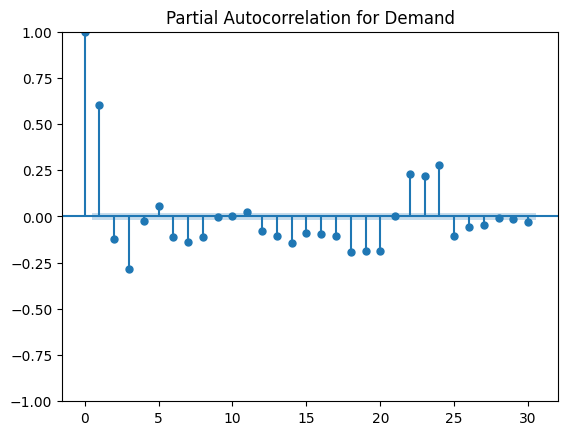

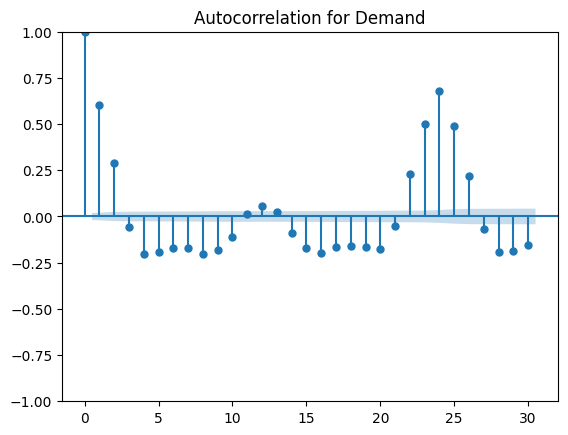

In [7]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# PACF for p
plot_pacf(train_df[target_column_name], lags=30)
plt.title("Partial Autocorrelation for Demand")
plt.show()

# ACF for q
plot_acf(train_df[target_column_name], lags=30)
plt.title("Autocorrelation for Demand")
plt.show()


In [8]:
model = auto_arima(train_df[target_column_name], start_p=0, start_q=0,
                            test='adf',       
                            max_p=10, max_q=10, 
                            m=1,              
                            d=None,           
                            seasonal=False,   
                            start_P=0, 
                            D=0, 
                            trace=False,
                            error_action='ignore',  
                            suppress_warnings=True, 
                            stepwise=True)

print(model.summary())

#Note: auto_arima uses a SARIMAX, but because I don't add any exogenous variables and seasonality is false, it is still an ARIMA model

#6,0,5

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                10663
Model:               SARIMAX(6, 0, 5)   Log Likelihood              -92644.384
Date:                Wed, 20 Mar 2024   AIC                         185314.768
Time:                        11:10:54   BIC                         185409.337
Sample:                             0   HQIC                        185346.677
                              - 10663                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.9642      3.317      0.291      0.771      -5.538       7.466
ar.L1          1.0876      0.041     26.654      0.000       1.008       1.168
ar.L2          0.1090      0.071      1.536      0.1

In [19]:
from tqdm import tqdm

def train_predict_ARIMA(train, steps, model):
    forecast = []
    forecast.append(model.predict(n_periods=steps))
    for i in tqdm(range(1, train.shape[0])):
        model.update(train[i-1,-1])
        forecast.append(model.predict(n_periods=steps))
    return np.array(forecast), model

In [20]:
# train_forecast, model = train_predict_ARIMA(ARIMA_X_train, 24, None)
val_pred, model = train_predict_ARIMA(ARIMA_X_val, 24, model)
test_pred, model = train_predict_ARIMA(ARIMA_X_test, 24, model)

  0%|          | 0/2237 [00:00<?, ?it/s]

  0%|          | 1/2237 [00:20<12:40:26, 20.41s/it]

In [ ]:
arima_y_val_pred = reformat_predictions_actual(val_pred, org_X_val)
arima_y_test_pred = reformat_predictions_actual(test_pred, org_X_test)

In [ ]:
arima_results = {"train": None, "val": val_pred, "test": test_pred, "formatted_train": None, "formatted_val":arima_y_val_pred, "formatted_test": arima_y_test_pred}

### RANDOM FOREST

In [ ]:
from sklearn.ensemble import RandomForestRegressor

X_train_flat = X_train.reshape(X_train.shape[0], -1)  
X_val_flat = X_val.reshape(X_val.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

In [ ]:
best_params = {
    'n_estimators': [50, 100, 200, 300, 400, 500, 600, 700, 800],  
    'max_features': [0.1, float(1/3), 2*float(1/3), 1] 
}

oob_errors = []
for n_estimators in best_params['n_estimators']:
    rf = RandomForestRegressor(
        n_estimators=n_estimators,
        max_features = float(1/3),
        oob_score=True,
        random_state=42)
    rf.fit(X_train_flat, y_train)
    oob_error = 1 - rf.oob_score_
    oob_errors.append(oob_error)
    print(f'{n_estimators} trees: OOB error = {oob_error}')

optimal_n_estimators = best_params['n_estimators'][oob_errors.index(min(oob_errors))]

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(best_params['n_estimators'], oob_errors, '-o', label='OOB Error Rate')
plt.title('OOB Error Rate vs. Number of Estimators')
plt.xlabel('Number of Estimators')
plt.ylabel('OOB Error Rate')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
optimal_depth = None
min_val_error = float('inf')
for max_f in best_params['max_features']:
    rf = RandomForestRegressor(
        n_estimators=500,
        max_features = max_f,
        random_state=42,
        n_jobs=-1
    )
    rf.fit(X_train_flat, y_train)
    val_pred = rf.predict(X_val_flat)
    val_error = mean_squared_error(y_val, val_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        optimal_depth = max_f
    print(f'Max depth = {max_f}: Validation MSE = {val_error}')

print(f'Optimal max depth: {optimal_depth}')

In [ ]:
rfmodel = RandomForestRegressor(
        n_estimators=500,
        max_depth=20,
        random_state=42,
        max_features = float(1/3),
        n_jobs=-1
    )
rfmodel.fit(X_train_flat, y_train)

RandomForestRegressor(max_depth=20, max_features=0.3333333333333333,
                      n_estimators=500, n_jobs=-1, random_state=42)

In [ ]:
train_pred = rfmodel.predict(X_train_flat)
val_pred = rfmodel.predict(X_val_flat)
test_pred = rfmodel.predict(X_test_flat)

rf_y_train_pred = reformat_predictions_actual(train_pred, org_X_train)
rf_y_val_pred = reformat_predictions_actual(val_pred, org_X_val)
rf_y_test_pred = reformat_predictions_actual(test_pred, org_X_test)

In [ ]:
rf_results = {"train": train_pred, "val": val_pred, "test": test_pred, "formatted_train": rf_y_train_pred, "formatted_val":rf_y_val_pred, "formatted_test": rf_y_test_pred}

### CNN-LSTM

In [ ]:
import tensorflow as tf
from keras.layers import Bidirectional, Dense, Conv1D,MaxPooling1D, Dropout, LSTM, ReLU, Flatten, TimeDistributed, RepeatVector, LeakyReLU
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

def build_lstm_model(X, y):
    tf.random.set_seed(22)
    
    cnn_lstm_model = Sequential()
    cnn_lstm_model.add((Conv1D(filters=64, kernel_size=3, padding='valid', input_shape= (X.shape[1],X.shape[2]))))
    cnn_lstm_model.add(MaxPooling1D(pool_size=2))
    cnn_lstm_model.add((Conv1D(filters=32, kernel_size=3, padding='valid')))
    cnn_lstm_model.add(MaxPooling1D(pool_size=2))
    cnn_lstm_model.add((Conv1D(filters=16, kernel_size=3, padding='valid')))
    cnn_lstm_model.add(MaxPooling1D(pool_size=2))
    cnn_lstm_model.add(Dropout(0.25))

    cnn_lstm_model.add(Flatten())

    cnn_lstm_model.add(RepeatVector(y.shape[1]))

    cnn_lstm_model.add(Bidirectional(LSTM(128, activation='swish', return_sequences=True)))
    cnn_lstm_model.add(Dropout(0.2))
    cnn_lstm_model.add(Flatten())
    cnn_lstm_model.add(RepeatVector(y.shape[1]))
    cnn_lstm_model.add(Bidirectional(LSTM(128, activation='swish', return_sequences=True)))
    cnn_lstm_model.add(Dropout(0.2))
    cnn_lstm_model.add(TimeDistributed(Dense(1)))
    cnn_lstm_model.compile(optimizer='adam', loss='mse')
    cnn_lstm_model.summary()
    return cnn_lstm_model

early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', restore_best_weights=True)


In [ ]:
cnn_lstm_model = build_lstm_model(scaled_X_train,scaled_y_train)

2024-03-20 10:20:42.669758: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-03-20 10:20:42.669993: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-03-20 10:20:42.670004: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-03-20 10:20:42.670255: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-03-20 10:20:42.670611: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 22, 64)            4096      
                                                                 
 max_pooling1d (MaxPooling1  (None, 11, 64)            0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 9, 32)             6176      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 4, 32)             0         
 g1D)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 2, 16)             1552      
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 1, 16)             0

In [ ]:
with tf.device('cpu:0'): #my mac gpu sucks and trains really slow for some reason
    training_history = cnn_lstm_model.fit(scaled_X_train,scaled_y_train, epochs=100, batch_size=64, validation_data=(scaled_X_val, scaled_y_val), verbose=1, callbacks=[early_stopping])

Epoch 1/100


2024-03-20 10:20:48.068401: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


166/166 [==============================] - 53s 303ms/step - loss: 0.0052 - val_loss: 0.0026
Epoch 2/100
166/166 [==============================] - 52s 312ms/step - loss: 0.0020 - val_loss: 0.0026
Epoch 3/100
166/166 [==============================] - 53s 317ms/step - loss: 0.0019 - val_loss: 0.0026
Epoch 4/100
166/166 [==============================] - 53s 318ms/step - loss: 0.0019 - val_loss: 0.0026
Epoch 5/100
166/166 [==============================] - 57s 341ms/step - loss: 0.0019 - val_loss: 0.0026
Epoch 6/100
166/166 [==============================] - 52s 312ms/step - loss: 0.0019 - val_loss: 0.0026
Epoch 7/100
166/166 [==============================] - 53s 317ms/step - loss: 0.0019 - val_loss: 0.0026
Epoch 8/100
 18/166 [==>...........................] - ETA: 45s - loss: 0.0019

KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(training_history.history['loss'], label='Training loss')
plt.plot(training_history.history['val_loss'], label='Validation loss')
plt.title('Training loss Vs. Validation loss')
plt.legend()

In [ ]:
train_pred = inverse_scaler.inverse_transform(cnn_lstm_model.predict(scaled_X_train).reshape(y_train.shape))
val_pred = inverse_scaler.inverse_transform(cnn_lstm_model.predict(scaled_X_val).reshape(y_val.shape))
test_pred = inverse_scaler.inverse_transform(cnn_lstm_model.predict(scaled_X_test).reshape(y_test.shape))
nn_y_train_pred = reformat_predictions_actual(train_pred, org_X_train)
nn_y_val_pred = reformat_predictions_actual(val_pred, org_X_val)
nn_y_test_pred = reformat_predictions_actual(test_pred, org_X_test)

In [ ]:
nn_results = {"train": train_pred, "val": val_pred, "test": test_pred, "formatted_train": nn_y_train_pred, "formatted_val":nn_y_val_pred, "formatted_test": nn_y_test_pred}

### SAVING PREDICTIONS

In [ ]:
demand_predictions = {"RF": rf_results,  "org": {"train": org_y_train, "val": org_y_val, "test": org_y_test}}

In [ ]:
demand_predictions = {"ARIMA": arima_results, "RF": rf_results, "nn": nn_results, "org": {"train": org_y_train, "val": org_y_val, "test": org_y_test}}

In [ ]:
import json 

with open("demand_predictions.json", "w") as outfile: 
    json.dump(demand_predictions, outfile)

## SOLAR FORECAST

In [ ]:
n_past = 24
n_future = 24
target_column_name = 'diff_supply'
train_df, val_df, test_df = df[1:int(len(df)*0.7)], df[int(len(df)*0.7):int(len(df)*0.7)+int(len(df)*0.15)], df[int(len(df)*0.7)+int(len(df)*0.15):] 
feature_column_names = [
    "installed_capacity",
    "dewpoint",
    "rain",
    "surface_pressure",
    "cloudcover_total",
    "cloudcover_low",
    "cloudcover_mid",
    "windspeed_10m",
    "shortwave_radiation",
    "direct_solar_radiation",
    # "lowest_price_per_mwh",
    # "euros_per_mwh",
    "24h_forecasted_cloudcover_low",
    "24h_forecasted_10_metre_u_wind_component",
    "24h_forecasted_10_metre_v_wind_component",
    "24h_forecasted_direct_solar_radiation",
    "24h_forecasted_surface_solar_radiation_downwards",
    "hour",
    "target_production",
    "diff_supply"
]

# feature_column_names = ['target', 'eic_count','forecasted_temperature','forecasted_direct_solar_radiation','forecasted_surface_solar_radiation_downwards','hour','month','day']

dataframe_scaler = MinMaxScaler()
dataframe_scaler = dataframe_scaler.fit(train_df)
inverse_scaler = MinMaxScaler()
inverse_scaler = inverse_scaler.fit(train_df[[target_column_name]])
scaled_train_df = pd.DataFrame(dataframe_scaler.transform(train_df), columns = train_df.columns)
scaled_val_df = pd.DataFrame(dataframe_scaler.transform(val_df), columns = val_df.columns)
scaled_test_df = pd.DataFrame(dataframe_scaler.transform(test_df), columns = test_df.columns)

scaled_X_train, scaled_y_train = split_series(scaled_train_df,n_past, n_future, target_column_name, feature_column_names)
scaled_X_val, scaled_y_val = split_series(scaled_val_df,n_past, n_future, target_column_name, feature_column_names)
scaled_X_test, scaled_y_test = split_series(scaled_test_df,n_past, n_future, target_column_name, feature_column_names)

X_train, y_train = split_series(train_df,n_past, n_future, target_column_name, feature_column_names)
X_val, y_val = split_series(val_df,n_past, n_future, target_column_name, feature_column_names)
X_test, y_test = split_series(test_df,n_past, n_future, target_column_name, feature_column_names)

ARIMA_X_train, ARIMA_y_train = split_series(train_df,n_past, n_future, target_column_name, target_column_name)
ARIMA_X_val, ARIMA_y_val = split_series(val_df,n_past, n_future, target_column_name, target_column_name)
ARIMA_X_test, ARIMA_y_test = split_series(test_df,n_past, n_future, target_column_name, target_column_name)

org_X_train, org_y_train = split_series(train_df,n_past, n_future, 'demand', 'demand')
org_X_val, org_y_val = split_series(val_df,n_past, n_future, 'demand', 'demand')
org_X_test, org_y_test = split_series(test_df,n_past, n_future, 'demand', 'demand')

### ARIMA

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# PACF for p
plot_pacf(train_df[target_column_name], lags=30)
plt.title("Partial Autocorrelation for Demand")
plt.show()

# ACF for q
plot_acf(train_df[target_column_name], lags=30)
plt.title("Autocorrelation for Demand")
plt.show()


In [ ]:
model = auto_arima(train_df[target_column_name], start_p=0, start_q=0,
                            test='adf',       
                            max_p=10, max_q=10, 
                            m=1,              
                            d=None,           
                            seasonal=False,   
                            start_P=0, 
                            D=0, 
                            trace=False,
                            error_action='ignore',  
                            suppress_warnings=True, 
                            stepwise=True)

print(model.summary())

#Note: auto_arima uses a SARIMAX, but because I don't add any exogenous variables and seasonality is false, it is still an ARIMA model

In [ ]:
from tqdm import tqdm

def train_predict_ARIMA(train, steps, model):
    forecast = []
    forecast.append(model.predict(n_periods=steps))
    for i in tqdm(range(1, train.shape[0])):
        model.update(train[i-1,-1])
        forecast.append(model.predict(n_periods=steps))
    return np.array(forecast), model

In [ ]:
# train_forecast, model = train_predict_ARIMA(ARIMA_X_train, 24, None)
val_pred, model = train_predict_ARIMA(ARIMA_X_val, 24, model)
test_pred, model = train_predict_ARIMA(ARIMA_X_test, 24, model)

In [ ]:
arima_y_val_pred = reformat_predictions_actual(val_pred, org_X_val)
arima_y_test_pred = reformat_predictions_actual(test_pred, org_X_test)

In [ ]:
arima_results = {"train": None, "val": val_pred, "test": test_pred, "formatted_train": None, "formatted_val":arima_y_val_pred, "formatted_test": arima_y_test_pred}

### RANDOM FOREST

In [ ]:
from sklearn.ensemble import RandomForestRegressor

X_train_flat = X_train.reshape(X_train.shape[0], -1)  
X_val_flat = X_val.reshape(X_val.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

In [ ]:
best_params = {
    'n_estimators': [50, 100, 200, 300, 400, 500, 600, 700, 800],  
    'max_depth': [None, 1, 5, 10, 20, 50] 
}

oob_errors = []
for n_estimators in best_params['n_estimators']:
    rf = RandomForestRegressor(
        n_estimators=n_estimators,
        max_features = float(1/3),
        oob_score=True,
        random_state=42)
    rf.fit(X_train_flat, y_train)
    oob_error = 1 - rf.oob_score_
    oob_errors.append(oob_error)
    print(f'{n_estimators} trees: OOB error = {oob_error}')

optimal_n_estimators = best_params['n_estimators'][oob_errors.index(min(oob_errors))]

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(best_params['n_estimators'], oob_errors, '-o', label='OOB Error Rate')
plt.title('OOB Error Rate vs. Number of Estimators')
plt.xlabel('Number of Estimators')
plt.ylabel('OOB Error Rate')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
best_params = {
    'n_estimators': [100, 200, 300, 400, 500, 600],  
    'max_depth': [None, 1, 5, 10, 20, 50, 100] 
}

optimal_depth = None
min_val_error = float('inf')
for depth in best_params['max_depth']:
    rf = RandomForestRegressor(
        n_estimators=500,
        max_depth=depth,
        max_features = float(1/3),
        random_state=42,
        n_jobs=-1
    )
    rf.fit(X_train_flat, y_train)
    val_pred = rf.predict(X_val_flat)
    val_error = mean_squared_error(y_val, val_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        optimal_depth = depth
    print(f'Max depth = {depth}: Validation MSE = {val_error}')

print(f'Optimal max depth: {optimal_depth}')

In [ ]:
rfmodel = RandomForestRegressor(
        n_estimators=500,
        max_depth=20,
        random_state=42,
        max_features = float(1/3),
        n_jobs=-1
    )
rfmodel.fit(X_train_flat, y_train)

In [ ]:
train_pred = rfmodel.predict(X_train_flat)
val_pred = rfmodel.predict(X_val_flat)
test_pred = rfmodel.predict(X_test_flat)

rf_y_train_pred = reformat_predictions_actual(train_pred, org_X_train)
rf_y_val_pred = reformat_predictions_actual(val_pred, org_X_val)
rf_y_test_pred = reformat_predictions_actual(test_pred, org_X_test)

In [ ]:
rf_results = {"train": train_pred, "val": val_pred, "test": test_pred, "formatted_train": rf_y_train_pred, "formatted_val":rf_y_val_pred, "formatted_test": rf_y_test_pred}

### CNN-LSTM

In [ ]:
import tensorflow as tf
from keras.layers import Bidirectional, Dense, Conv1D,MaxPooling1D, Dropout, LSTM, ReLU, Flatten, TimeDistributed, RepeatVector, LeakyReLU
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflokeras.callbacks import EarlyStopping

def build_lstm_model(X, y):
    tf.random.set_seed(22)
    
    cnn_lstm_model = Sequential()
    cnn_lstm_model.add((Conv1D(filters=64, kernel_size=3, padding='valid', input_shape= (X.shape[1],X.shape[2]))))
    cnn_lstm_model.add(MaxPooling1D(pool_size=2))
    cnn_lstm_model.add((Conv1D(filters=32, kernel_size=3, padding='valid')))
    cnn_lstm_model.add(MaxPooling1D(pool_size=2))
    cnn_lstm_model.add((Conv1D(filters=16, kernel_size=3, padding='valid')))
    cnn_lstm_model.add(MaxPooling1D(pool_size=2))
    cnn_lstm_model.add(Dropout(0.25))

    cnn_lstm_model.add(Flatten())

    cnn_lstm_model.add(RepeatVector(y.shape[1]))

    cnn_lstm_model.add(Bidirectional(LSTM(128, activation='swish', return_sequences=True)))
    cnn_lstm_model.add(Dropout(0.2))
    cnn_lstm_model.add(Flatten())
    cnn_lstm_model.add(RepeatVector(y.shape[1]))
    cnn_lstm_model.add(Bidirectional(LSTM(128, activation='swish', return_sequences=True)))
    cnn_lstm_model.add(Dropout(0.2))
    cnn_lstm_model.add(TimeDistributed(Dense(1)))
    cnn_lstm_model.compile(optimizer='adam', loss='mse')
    cnn_lstm_model.summary()
    return cnn_lstm_model

early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', restore_best_weights=True)


In [ ]:
cnn_lstm_model = build_lstm_model(scaled_X_train,scaled_y_train)

In [ ]:
with tf.device('cpu:0'): #my mac gpu sucks and trains really slow for some reason
    training_history = cnn_lstm_model.fit(scaled_X_train,scaled_y_train, epochs=100, batch_size=64, validation_data=(scaled_X_val, scaled_y_val), verbose=1, callbacks=[early_stopping])

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(training_history.history['loss'], label='Training loss')
plt.plot(training_history.history['val_loss'], label='Validation loss')
plt.title('Training loss Vs. Validation loss')
plt.legend()

In [ ]:
train_pred = inverse_scaler.inverse_transform(cnn_lstm_model.predict(scaled_X_train).reshape(y_train.shape))
val_pred = inverse_scaler.inverse_transform(cnn_lstm_model.predict(scaled_X_val).reshape(y_val.shape))
test_pred = inverse_scaler.inverse_transform(cnn_lstm_model.predict(scaled_X_test).reshape(y_test.shape))
nn_y_train_pred = reformat_predictions_actual(train_pred, org_X_train)
nn_y_val_pred = reformat_predictions_actual(val_pred, org_X_val)
nn_y_test_pred = reformat_predictions_actual(test_pred, org_X_test)

In [ ]:
nn_results = {"train": train_pred, "val": val_pred, "test": test_pred, "formatted_train": nn_y_train_pred, "formatted_val":nn_y_val_pred, "formatted_test": nn_y_test_pred}

### SAVING PREDICTIONS

In [ ]:
solar_predictions = {"ARIMA": arima_results, "RF": rf_results, "nn": nn_results, "org": {"train": org_y_train, "val": org_y_val, "test": org_y_test}}

In [ ]:
import json 

with open("solar_predictions.json", "w") as outfile: 
    json.dump(solar_predictions, outfile)

## ANALYSIS OF RESULTS

In [53]:
choice = demand_predictions
model = "RF"
# RF, nn

In [54]:
choice[model].keys()

dict_keys(['train', 'val', 'test', 'formatted_train', 'formatted_val', 'formatted_test'])

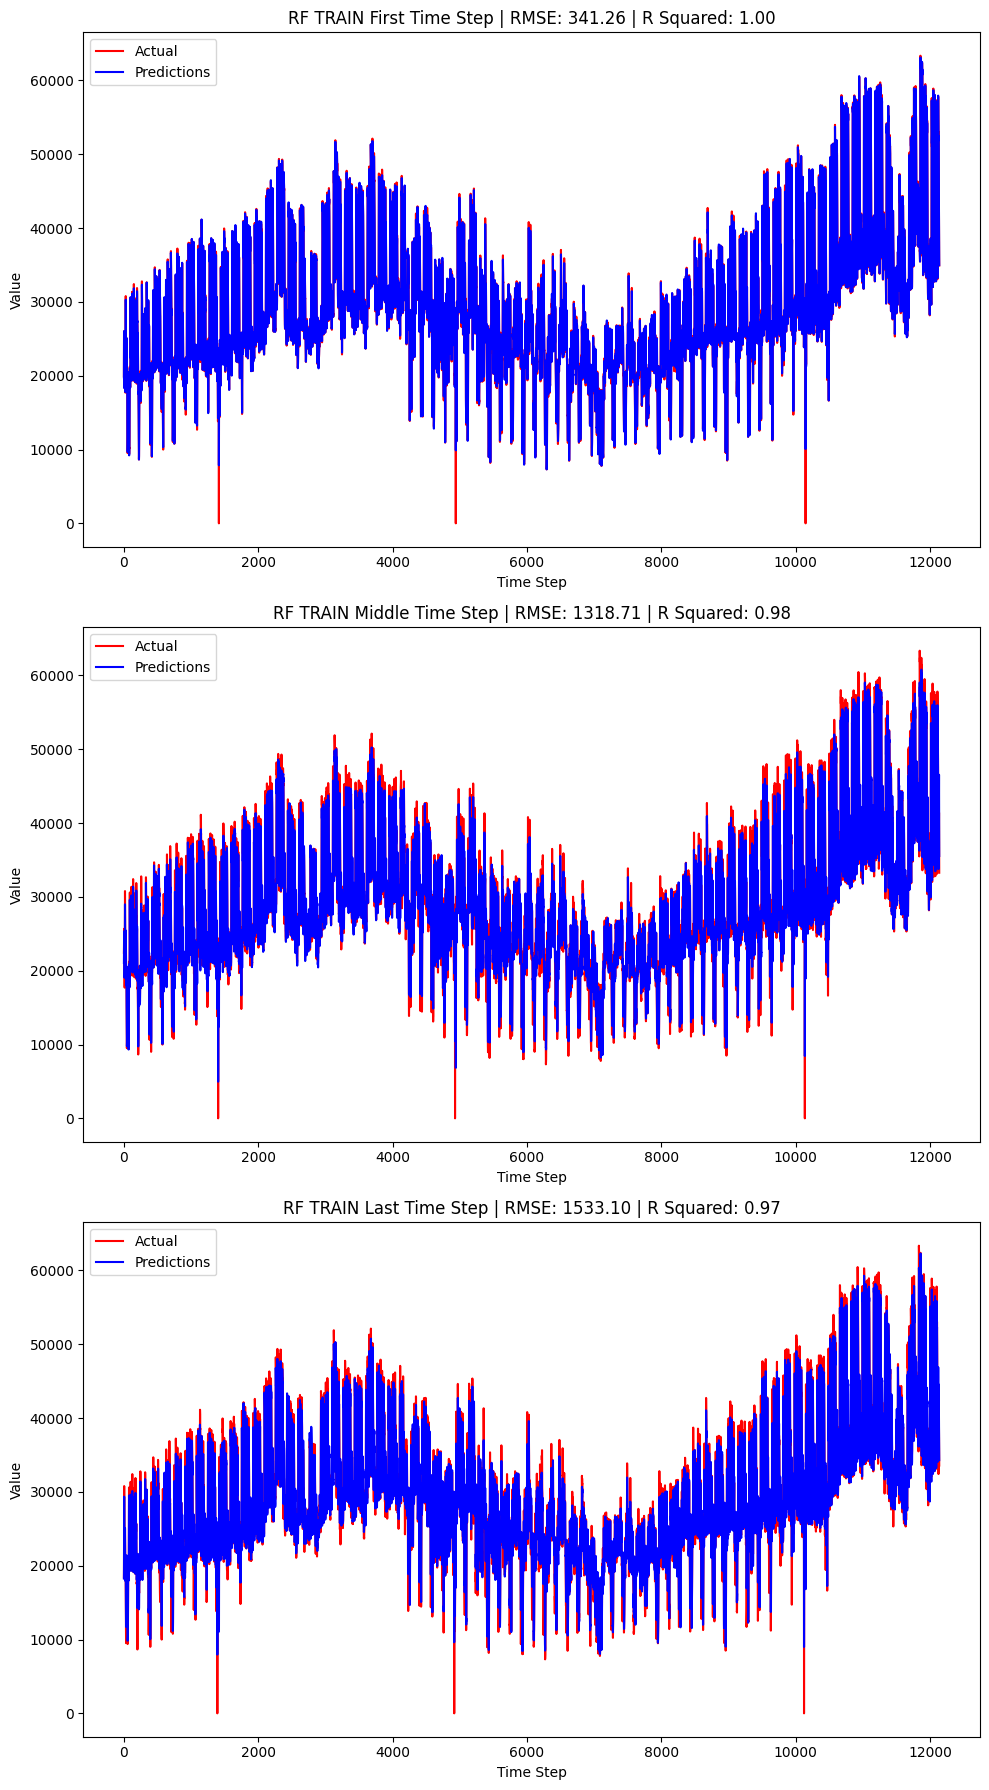

In [55]:
time_steps = [0, 11, 23]
titles = ['First Time Step', 'Middle Time Step', 'Last Time Step']

fig, axs = plt.subplots(3, 1, figsize=(10, 18))

for i, ax in enumerate(axs):
    time_step = time_steps[i]

    ax.plot(choice['org']['train'][:, time_step], label='Actual', color='red')
    ax.plot(choice[model]['formatted_train'][:, time_step], label='Predictions', color='blue')

    rmse = np.sqrt(mean_squared_error(choice['org']['train'][:, time_step], choice[model]['formatted_train'][:, time_step]))
    r2 = r2_score(choice['org']['train'][:, time_step], choice[model]['formatted_train'][:, time_step])
    ax.set_title(f'{model} TRAIN {titles[i]} | RMSE: {rmse:.2f} | R Squared: {r2:.2f}')
    ax.set_xlabel('Time Step')
    ax.set_ylabel('Value')
    ax.legend()

plt.tight_layout()
plt.show()



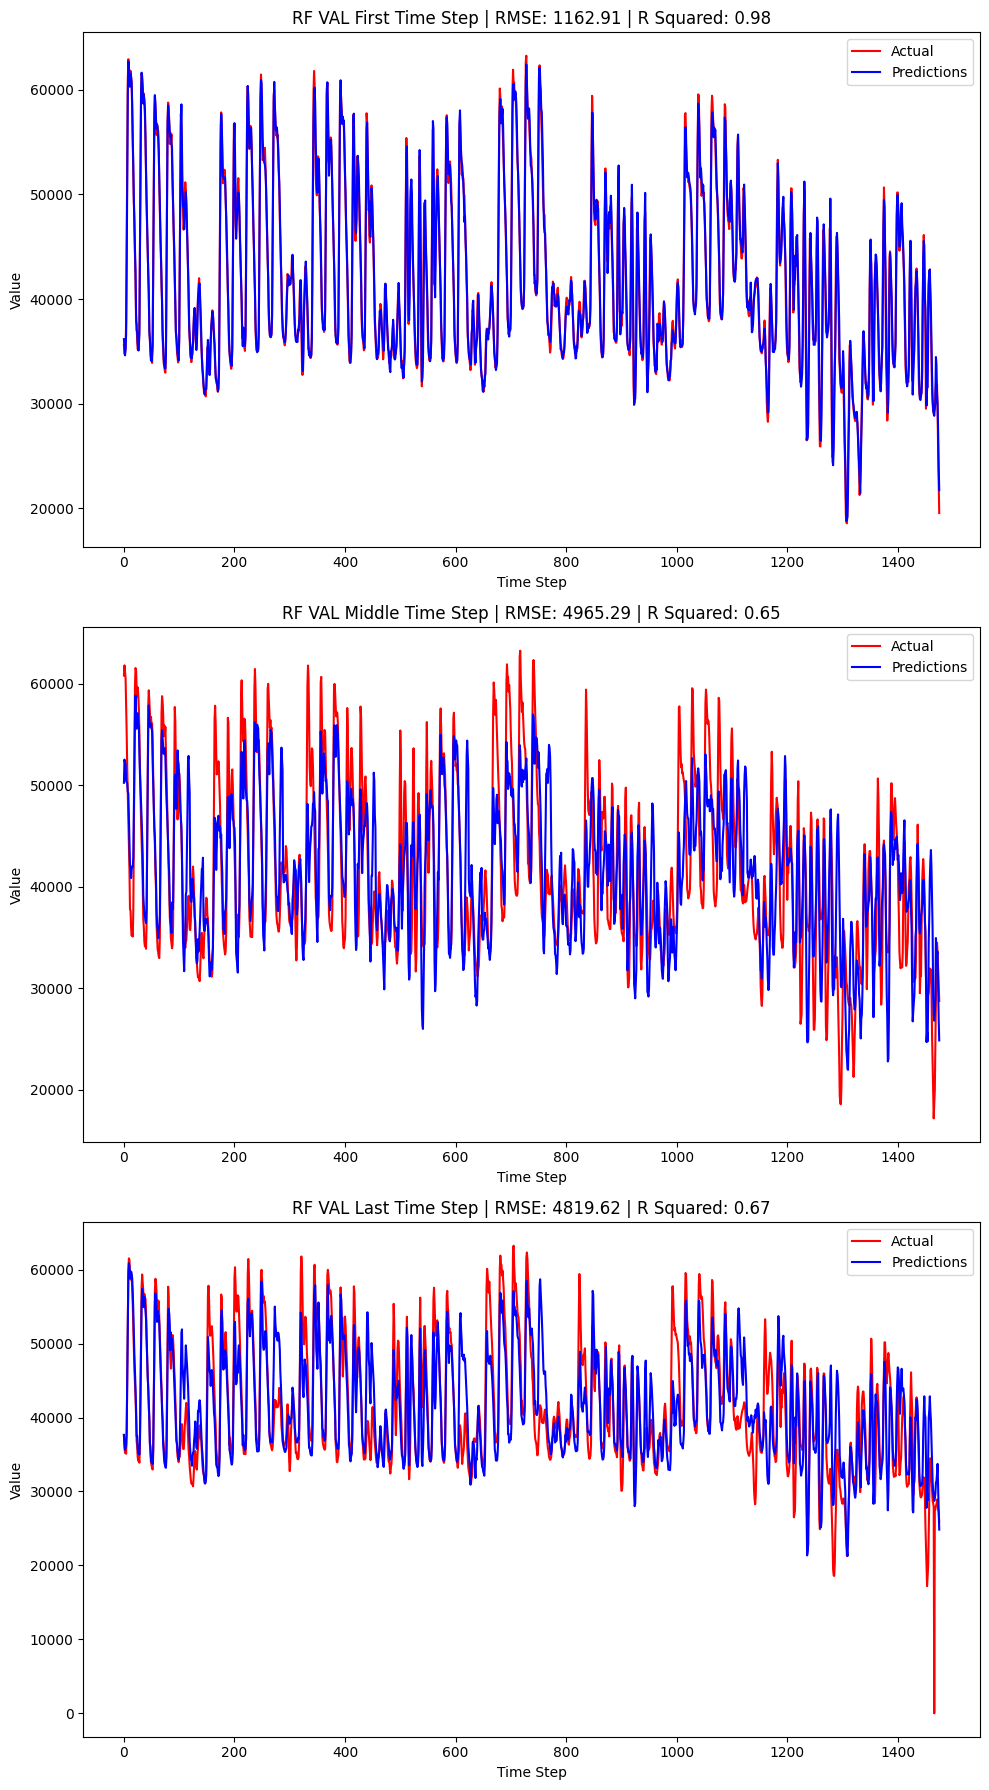

In [56]:
time_steps = [0, 11, 23]
titles = ['First Time Step', 'Middle Time Step', 'Last Time Step']

fig, axs = plt.subplots(3, 1, figsize=(10, 18))

for i, ax in enumerate(axs):
    time_step = time_steps[i]

    ax.plot(choice['org']['val'][:, time_step], label='Actual', color='red')
    ax.plot(choice[model]['formatted_val'][:, time_step], label='Predictions', color='blue')

    rmse = np.sqrt(mean_squared_error(choice['org']['val'][:, time_step], choice[model]['formatted_val'][:, time_step]))
    r2 = r2_score(choice['org']['val'][:, time_step], choice[model]['formatted_val'][:, time_step])

    ax.set_title(f'{model} VAL {titles[i]} | RMSE: {rmse:.2f} | R Squared: {r2:.2f}')
    ax.set_xlabel('Time Step')
    ax.set_ylabel('Value')
    ax.legend()

plt.tight_layout()
plt.show()



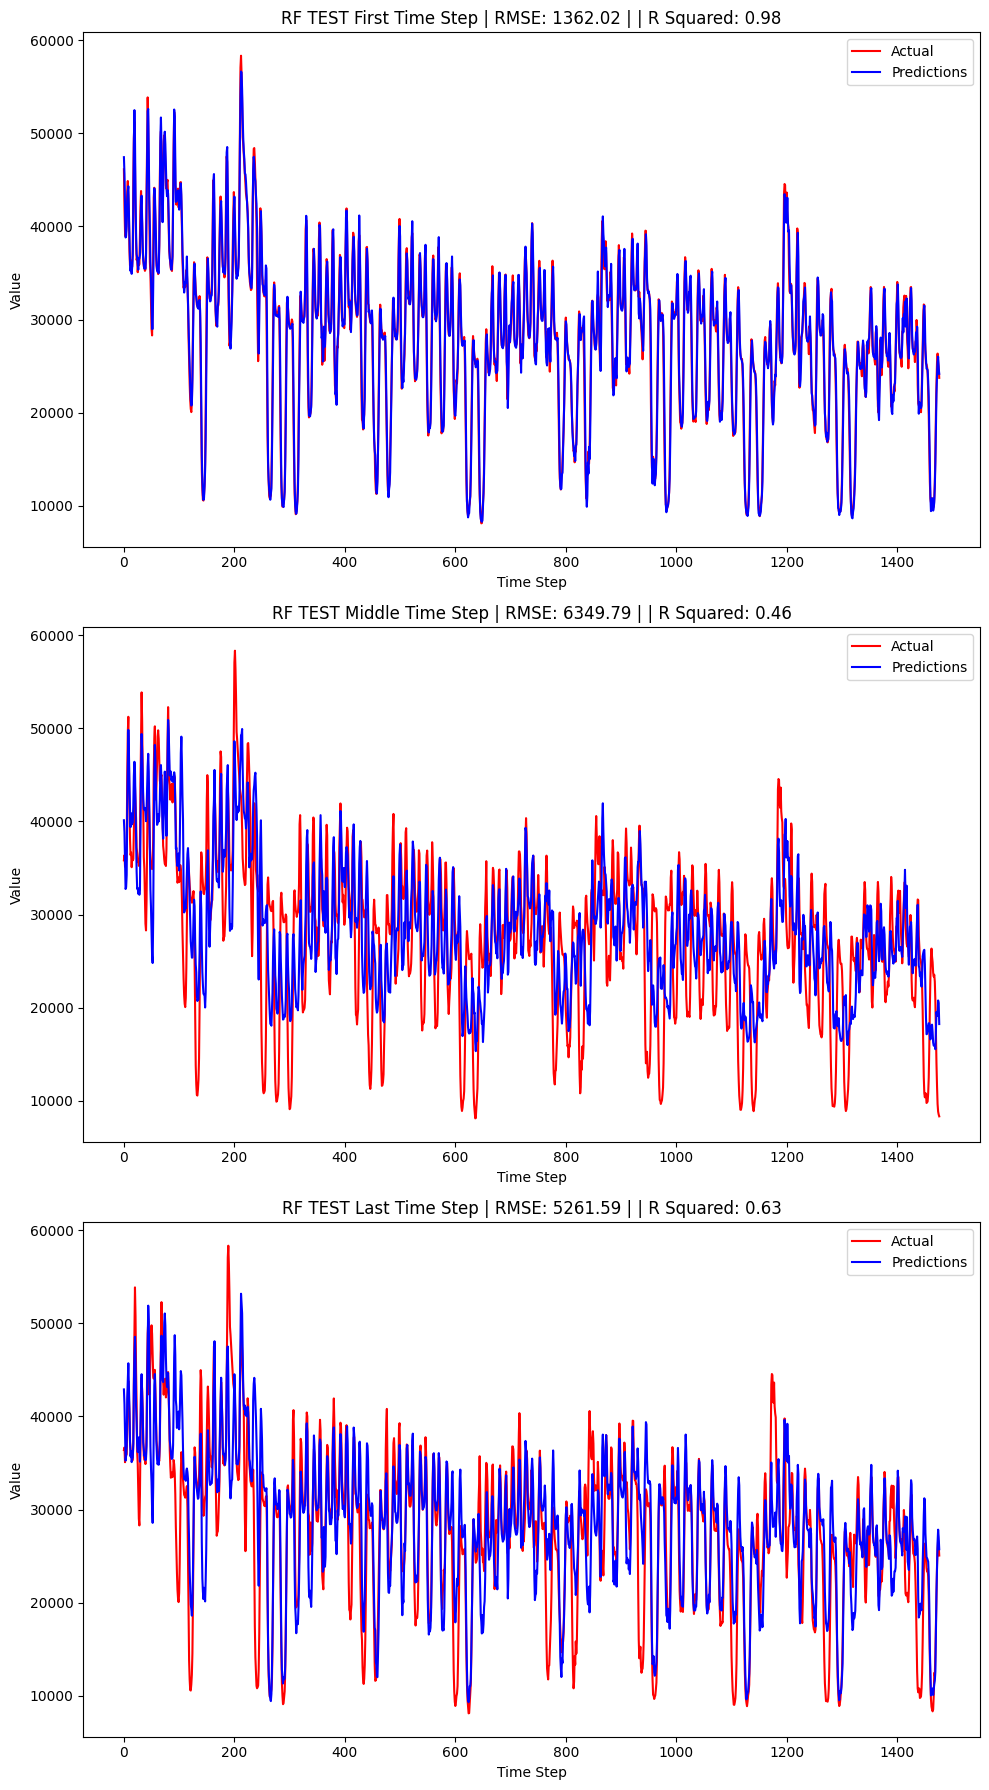

In [57]:
time_steps = [0, 11, 23]
titles = ['First Time Step', 'Middle Time Step', 'Last Time Step']

fig, axs = plt.subplots(3, 1, figsize=(10, 18))

for i, ax in enumerate(axs):
    time_step = time_steps[i]

    ax.plot(choice['org']['test'][:, time_step], label='Actual', color='red')
    ax.plot(choice[model]['formatted_test'][:, time_step], label='Predictions', color='blue')

    rmse = np.sqrt(mean_squared_error(choice['org']['test'][:, time_step], choice[model]['formatted_test'][:, time_step]))
    r2 = r2_score(choice['org']['test'][:, time_step], choice[model]['formatted_test'][:, time_step])

    ax.set_title(f'{model} TEST {titles[i]} | RMSE: {rmse:.2f} | | R Squared: {r2:.2f}')
    ax.set_xlabel('Time Step')
    ax.set_ylabel('Value')
    ax.legend()

plt.tight_layout()
plt.show()

